# 네이버 영화리뷰 감성분석 도전하기

In [1]:
# import

import os
import re
import pandas as pd
import numpy as np

import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline


from konlpy.tag import Okt
from konlpy.tag import Mecab

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from collections import Counter
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [5]:
#data set

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/data/ratings_train.txt')
test_data = pd.read_table('~/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [7]:
def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [8]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

index_to_word = {index:word for word, index in word_to_index.items()}

len(word_to_index)

10000

In [9]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

----------------------------------------------------------------------------------------------------------------------

In [10]:
## Preprocessing


# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [11]:
# 적절한 최대 문장 길이 지정
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  48
전체 문장의 0.9548784420929768%가 maxlen 설정값 이내에 포함됩니다. 


In [13]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 48)
(49157, 48)


In [15]:
# validation set 30000건 분리
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(x_val.shape)
print(y_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(30000, 48)
(30000,)
(116182, 48)
(116182,)


----------------------------------------------------------------------------------------------------------------------

In [17]:
## Model - LSTM

vocab_size = 10000
word_vector_dim = 128

LSTM_ = keras.Sequential()
LSTM_.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_.add(keras.layers.LSTM(128))
LSTM_.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM_.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


In [18]:
## Train

LSTM_.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

LSTM_history = LSTM_.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[early, check],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
3631/3631 [==============================] - 31s 6ms/step - loss: 0.3691 - accuracy: 0.8348 - val_loss: 0.3153 - val_accuracy: 0.8633

Epoch 00001: saving model to best_model.h5
Epoch 2/20
3631/3631 [==============================] - 22s 6ms/step - loss: 0.2822 - accuracy: 0.8810 - val_loss: 0.3118 - val_accuracy: 0.8653

Epoch 00002: saving model to best_model.h5
Epoch 3/20
3631/3631 [==============================] - 23s 6ms/step - loss: 0.2373 - accuracy: 0.9023 - val_loss: 0.3297 - val_accuracy: 0.8607

Epoch 00003: saving model to best_model.h5
Epoch 4/20
3631/3631 [==============================] - 23s 6ms/step - loss: 0.1966 - accuracy: 0.9205 - val_loss: 0.3521 - val_accuracy: 0.8623

Epoch 00004: saving model to best_model.h5
Epoch 5/20
3631/3631 [==============================] - 23s 6ms/step - loss: 0.1596 - accuracy: 0.9362 - val_loss: 0.3822 - val_accuracy: 0.8586

Epoch 00005: saving model to best_model.h5
Epoch 6/20
3631/3631 [==============================] -

In [19]:
loaded_model = load_model('best_model.h5')
results = loaded_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.5146 - accuracy: 0.8500
[0.5146243572235107, 0.8500315546989441]


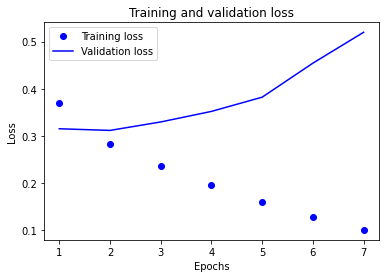

In [20]:
## Visualization

LSTM_history_dict = LSTM_history.history

acc = LSTM_history_dict['accuracy']
val_acc = LSTM_history_dict['val_accuracy']
loss = LSTM_history_dict['loss']
val_loss = LSTM_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

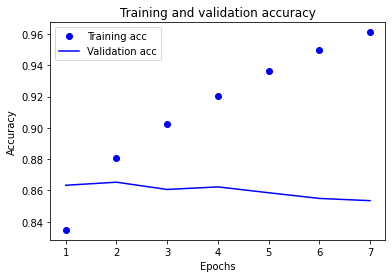

In [21]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [22]:
## Embedding layer

embedding_layer = LSTM_.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 128)


In [25]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/LSTMword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = LSTM_.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [26]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.09004937, -0.06181082, -0.13693796, -0.0881693 ,  0.18022098,
       -0.08879134,  0.20564355,  0.1623854 ,  0.50387275, -0.34973085,
       -0.25117788,  0.11338192, -0.11119253, -0.04693395, -0.01771899,
        0.12723526, -0.09822405,  0.29103568, -0.07780316, -0.00145743,
       -0.19984649,  0.07972922, -0.07862218,  0.10989869,  0.11945824,
        0.15493779,  0.07595786, -0.12253202,  0.03469127,  0.0176244 ,
        0.2299974 , -0.03892991,  0.036629  , -0.03770838,  0.12051015,
        0.2570357 ,  0.10161662, -0.03772451, -0.14632422,  0.26811057,
       -0.02417257,  0.08717475, -0.10918115, -0.30940443, -0.04373933,
       -0.0227317 ,  0.18894003,  0.00126899,  0.15840065, -0.28293985,
        0.01979633, -0.0132147 ,  0.25348198,  0.3809597 ,  0.3988198 ,
       -0.00313765,  0.01400252, -0.02085353, -0.00880098,  0.05604286,
       -0.00463601, -0.00735279, -0.07326268, -0.08264145,  0.03673401,
        0.26112354,  0.12415631, -0.1404311 , -0.04349902, -0.03

In [27]:
word_vectors.similar_by_word("감동")


[('싯', 0.8442404270172119),
 ('친근', 0.8416017293930054),
 ('리암니슨', 0.841248095035553),
 ('숨소리', 0.8357841372489929),
 ('커버', 0.8338183164596558),
 ('앓', 0.8334214687347412),
 ('이만큼', 0.8270056247711182),
 ('예쁨', 0.826521635055542),
 ('윤계상', 0.826279878616333),
 ('잠기', 0.8257102966308594)]

In [47]:
# 한국어 Word2Vec 임베딩 활용한 성능 개선
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME') + '/aiffel/sentiment_classification/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

vector = word2vec['전술']
vector     

AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.9/site-packages/gensim/models/word2vec.py'>

In [37]:
word2vec.similar_by_word("감동")

NameError: name 'word2vec' is not defined

In [46]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

NameError: name 'word2vec' is not defined

----------------------------------------------------------------------------------------------------------------------

In [48]:
## model - Conv1D

vocab_size = 10000
word_vector_dim = 64

conv1d_model = keras.Sequential()
conv1d_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
conv1d_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model.add(keras.layers.MaxPooling1D(5))
conv1d_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model.add(keras.layers.GlobalMaxPooling1D())
conv1d_model.add(keras.layers.Dense(128, activation='relu'))
conv1d_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [49]:
conv1d_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          28736     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [51]:
## train

conv1d_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

conv1d_history = conv1d_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 21s 5ms/step - loss: 0.4142 - accuracy: 0.8017 - val_loss: 0.3675 - val_accuracy: 0.8287
Epoch 2/10
3631/3631 [==============================] - 18s 5ms/step - loss: 0.3112 - accuracy: 0.8618 - val_loss: 0.3642 - val_accuracy: 0.8316
Epoch 3/10
3631/3631 [==============================] - 18s 5ms/step - loss: 0.2341 - accuracy: 0.8990 - val_loss: 0.4051 - val_accuracy: 0.8233
Epoch 4/10
3631/3631 [==============================] - 18s 5ms/step - loss: 0.1663 - accuracy: 0.9291 - val_loss: 0.4768 - val_accuracy: 0.8216
Epoch 5/10
3631/3631 [==============================] - 18s 5ms/step - loss: 0.1243 - accuracy: 0.9465 - val_loss: 0.6017 - val_accuracy: 0.8169
Epoch 6/10
3631/3631 [==============================] - 18s 5ms/step - loss: 0.1004 - accuracy: 0.9555 - val_loss: 0.7048 - val_accuracy: 0.8117
Epoch 7/10
3631/3631 [==============================] - 18s 5ms/step - loss: 0.0847 - accuracy: 0.9613 - val_loss: 0.7595 - val_ac

In [52]:
results = conv1d_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.0916 - accuracy: 0.8005
[1.0916173458099365, 0.8005167245864868]


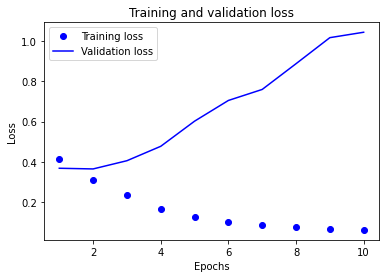

In [54]:
## visualization

conv1d_history_dict = conv1d_history.history

acc = conv1d_history_dict['accuracy']
val_acc = conv1d_history_dict['val_accuracy']
loss = conv1d_history_dict['loss']
val_loss = conv1d_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

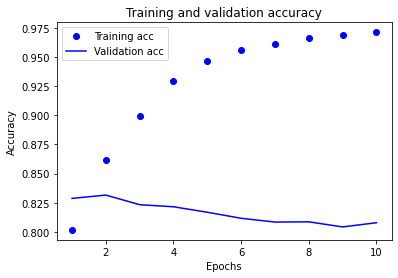

In [55]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [56]:
## Embedding layer


embedding_layer = conv1d_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 64)


In [57]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/conv1d_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = conv1d_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [58]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.06654944, -0.1601328 ,  0.0474739 , -0.34891737, -0.07400934,
        0.24356729,  0.04373816, -0.13889259, -0.1632616 ,  0.16555949,
       -0.18885724, -0.2454773 ,  0.23993333,  0.02212934,  0.18625298,
        0.0136276 ,  0.04210281, -0.02516148, -0.07236808, -0.00867972,
       -0.13997544,  0.04813735, -0.26524574,  0.09506819,  0.09908339,
        0.04762689, -0.05216658,  0.1877986 , -0.1394391 ,  0.10781422,
        0.07170675,  0.09868671, -0.16939765,  0.0911404 , -0.15803602,
        0.25578406, -0.01753247, -0.07905128, -0.25602058, -0.05397232,
        0.02512054, -0.0635207 ,  0.21041481,  0.11814352, -0.10398073,
       -0.01047717,  0.13660704, -0.05693089, -0.2995325 , -0.14971948,
        0.24344677,  0.3085537 , -0.1626546 ,  0.06427041,  0.00131592,
        0.03409213,  0.00680231, -0.15752426, -0.06919546, -0.07907993,
       -0.02286597,  0.12995547, -0.01521298, -0.14713997], dtype=float32)

In [59]:
word_vectors.similar_by_word("감동")


[('하비에르', 0.7086957693099976),
 ('정겹', 0.6864585876464844),
 ('돌아와', 0.6788815259933472),
 ('아낌없', 0.6771109700202942),
 ('홧팅', 0.6707474589347839),
 ('슬픔', 0.6706838011741638),
 ('들이', 0.6647776365280151),
 ('엉엉', 0.6587197184562683),
 ('아름다워서', 0.6581196784973145),
 ('펭귄', 0.6562592387199402)]

In [60]:
## 한국어 Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.9/site-packages/gensim/models/word2vec.py'>

----------------------------------------------------------------------------------------------------------------------

In [61]:
## Model - GlobalMaxPooling

vocab_size = 10000
word_vector_dim = 64

GMP_model = keras.Sequential()
GMP_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='relu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))

GMP_model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 640,529
Trainable params: 640,529
Non-trainable params: 0
_________________________________________________________________


In [63]:
## train


GMP_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

GMP_history = GMP_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 13s 3ms/step - loss: 0.3930 - accuracy: 0.8226 - val_loss: 0.3409 - val_accuracy: 0.8517
Epoch 2/10
3631/3631 [==============================] - 12s 3ms/step - loss: 0.3040 - accuracy: 0.8713 - val_loss: 0.3389 - val_accuracy: 0.8546
Epoch 3/10
3631/3631 [==============================] - 12s 3ms/step - loss: 0.2621 - accuracy: 0.8922 - val_loss: 0.3483 - val_accuracy: 0.8516
Epoch 4/10
3631/3631 [==============================] - 12s 3ms/step - loss: 0.2268 - accuracy: 0.9099 - val_loss: 0.3664 - val_accuracy: 0.8520
Epoch 5/10
3631/3631 [==============================] - 12s 3ms/step - loss: 0.1950 - accuracy: 0.9246 - val_loss: 0.3941 - val_accuracy: 0.8482
Epoch 6/10
3631/3631 [==============================] - 12s 3ms/step - loss: 0.1651 - accuracy: 0.9373 - val_loss: 0.4262 - val_accuracy: 0.8455
Epoch 7/10
3631/3631 [==============================] - 12s 3ms/step - loss: 0.1399 - accuracy: 0.9480 - val_loss: 0.4830 - val_ac

In [64]:
results = GMP_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6644 - accuracy: 0.8277
[0.6644426584243774, 0.8276745676994324]


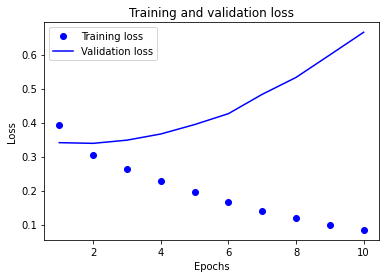

In [65]:
## visualization

GMP_history_dict = GMP_history.history

acc = GMP_history_dict['accuracy']
val_acc = GMP_history_dict['val_accuracy']
loss = GMP_history_dict['loss']
val_loss = GMP_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

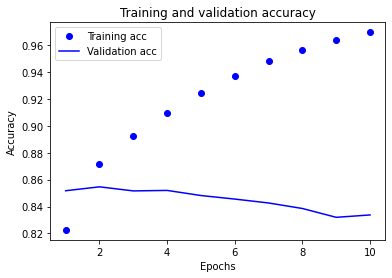

In [66]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [67]:
## Embedding layer

embedding_layer = GMP_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 64)


In [69]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GMP_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = GMP_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.11648685, -0.21330824,  0.0067131 , -0.09781674, -0.11743326,
       -0.04550837, -0.06538764,  0.0946768 , -0.03108697, -0.12225331,
       -0.10820971, -0.03231138, -0.01463701,  0.14983772, -0.14836498,
       -0.01520548,  0.16406313,  0.23196562, -0.01758005, -0.1830369 ,
        0.13647197, -0.05039364, -0.08832896, -0.1295543 ,  0.20868646,
       -0.01515863, -0.17661235, -0.18977696,  0.20345847, -0.17413534,
       -0.04773805, -0.13550359, -0.18902728,  0.07460945, -0.15956682,
       -0.12468125,  0.03486157, -0.13938384, -0.12042249,  0.21266557,
       -0.17249145, -0.04013007,  0.06180929, -0.05426881,  0.03093631,
        0.12804613,  0.05678658, -0.12681639, -0.10852946, -0.21873078,
       -0.17827561, -0.18277206,  0.0764302 , -0.04995326, -0.1951327 ,
       -0.1404116 , -0.00554239, -0.17334707, -0.13330379, -0.06598181,
       -0.02525312, -0.09513229,  0.06589829, -0.07168194], dtype=float32)

In [70]:
word_vectors.similar_by_word("감동")


[('던데', 0.7970153093338013),
 ('오호', 0.7562087774276733),
 ('기억', 0.7554038763046265),
 ('짜임새', 0.7550135254859924),
 ('심오', 0.7507134675979614),
 ('짱짱', 0.7403030395507812),
 ('며', 0.7391543984413147),
 ('으면서', 0.7362026572227478),
 ('봤', 0.7335835695266724),
 ('남', 0.731278121471405)]

In [71]:
## 한국어 Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.9/site-packages/gensim/models/word2vec.py'>

In [72]:
vocab_size = 10000
word_vector_dim = 200

GMP_model_ko = keras.Sequential()
GMP_model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
GMP_model_ko.add(keras.layers.GlobalMaxPooling1D())
GMP_model_ko.add(keras.layers.Dense(8, activation='relu'))
GMP_model_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [73]:
GMP_model_ko.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [74]:
GMP_model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [75]:
history = GMP_model_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 14s 4ms/step - loss: 0.4226 - accuracy: 0.8041 - val_loss: 0.3399 - val_accuracy: 0.8522
Epoch 2/10
3631/3631 [==============================] - 13s 4ms/step - loss: 0.3089 - accuracy: 0.8693 - val_loss: 0.3370 - val_accuracy: 0.8546
Epoch 3/10
3631/3631 [==============================] - 13s 4ms/step - loss: 0.2667 - accuracy: 0.8906 - val_loss: 0.3399 - val_accuracy: 0.8542
Epoch 4/10
3631/3631 [==============================] - 13s 4ms/step - loss: 0.2300 - accuracy: 0.9085 - val_loss: 0.3465 - val_accuracy: 0.8561
Epoch 5/10
3631/3631 [==============================] - 13s 4ms/step - loss: 0.1957 - accuracy: 0.9240 - val_loss: 0.3725 - val_accuracy: 0.8535
Epoch 6/10
3631/3631 [==============================] - 13s 4ms/step - loss: 0.1596 - accuracy: 0.9413 - val_loss: 0.4068 - val_accuracy: 0.8499
Epoch 7/10
3631/3631 [==============================] - 13s 4ms/step - loss: 0.1270 - accuracy: 0.9555 - val_loss: 0.4457 - val_ac

In [76]:
results = GMP_model_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.7022 - accuracy: 0.8309
[0.7021945714950562, 0.8309294581413269]


----------------------------------------------------------------------------------------------------------------------

# 회고

정확도를 85%로 올리기 위해 LSTM, Conv1D, GlobalMaxPooling 3가지 모델에서 이것저것 변화시켜 보았지만 85%는 넘을 수가 없었다. 이 중 LSTM의 성능이 가장 좋았으며 유일하게 LSTM 만 85%를 넘을 수 있었다. 또한, pre가 훨씬 유리하며 10% 이상의 테스트 성능 차이를 보인다.

한국어 Word2Vec도 사용해보려고 했는데, cloud shell에서 gensim 버전을 낮추고자 $ pip install --upgrade gensim==3.8.3을 했는데도 계속 에러가 뜬다. pip list | grep gensim로 버전이 3.8.3임을 확인했는데도 계속 에러가 떠서 사용하지 못했다. ko.bin 경로 또한 정확하게 다운로드하고 불러왔다. 
아마 한국어 word2vec를 사용하면 성능이 더 올라갈 것으로 예상이 된다.